# Computer-assisted drug discovery

Group assignment startup challenge - CADD technologies

In [1]:
%matplotlib inline
#General imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Imports needed for processing of input data
from rdkit.Chem import (Descriptors,
                        AllChem
                       )
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors

# Imports needed for PCA application
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Imports needed for Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (train_test_split,
                                     cross_val_score
                                    )
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             confusion_matrix,
                             balanced_accuracy_score
                            )


## Dataset preparation

Calculation of various types of molecular descriptors.

In [2]:
def load_data(file):
    """
    Load the tested_molecules_v2.csv datasets.
    
    Args:
        file (str): The file name.
    
    Returns:
        pd.DataFrame: A dataframe of loaded csv file (df).
    """
    df = pd.read_csv(file)
    
    return df

In [3]:
# Load in the necessary file to determine the descriptors and train the model.
data = load_data("tested_molecules_v2.csv")

In [4]:
def calculate_descriptors(smiles):
    """
    Calculate molecular descriptors for a given SMILES string.
    
    Args:
        smiles (str): The SMILES string of the molecule.
    
    Returns:
        pd.Series: Series of descriptor values.
    """
    mol = Chem.MolFromSmiles(smiles)
    desc_values = calc.CalcDescriptors(mol)
    
    return pd.Series(desc_values, index=desc_list).dropna()

In [5]:
# Create a list of all 209 molecular descriptors, which could be obtained from Descriptors._descList.
desc_list = [n[0] for n in Descriptors._descList]

# Create a descriptor calculator that can calculate the values of multiple descriptors for a specific molecule.
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)

# Calculate descriptors for each SMILES string, and removing SMILES and inhibition information.
data[desc_list] = data['SMILES'].apply(calculate_descriptors)  
columns = data.columns[2:]
descriptor_data = pd.DataFrame(data[columns], columns=columns)

C:\Users\20161641\AppData\Local\Temp\ipykernel_1692\1145482261.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[desc_list] = data['SMILES'].apply(calculate_descriptors)
C:\Users\20161641\AppData\Local\Temp\ipykernel_1692\1145482261.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[desc_list] = data['SMILES'].apply(calculate_descriptors)
C:\Users\20161641\AppData\Local\Temp\ipykernel_1692\1145482261.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many 

In [6]:
def big_clean(descriptor_data):
    """
    Perform data cleaning operations on the descriptor data.
    
    Args:
        descriptor_data (pd.DataFrame): Descriptor data.
    
    Returns:
        pd.DataFrame: Cleaned descriptor data.
        list: List of columns with all zero values.
    """
    # Drop rows and columns with NaN values
    descriptor_data.dropna(axis=0).dropna(axis=1)  
    
    # Drop duplicate rows
    descriptor_data.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False) 
        
    # Check if all values in a column are zero
    zero_columns = []
    for column in descriptor_data:
        if (descriptor_data[column] == 0).all() == True:  
            zero_columns.append(column)
    
    # Drop columns with all zero values
    descriptor_data.drop(columns=zero_columns, inplace=True)  
    
    return descriptor_data

In [7]:
def remove_highly_correlated_columns(df, threshold):
    """
    Remove highly correlated columns from a DataFrame based on a correlation threshold.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        threshold (float): Correlation threshold for removal.
    
    Returns:
        pd.DataFrame: DataFrame with highly correlated columns removed.
        list: List of highly correlated columns.
    """
    # Get upper triangle of the correlation matrix
    correlation_matrix = df.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape, dtype=bool), k=1)
    )  
    
    # Check if any correlation value is above the threshold
    highly_correlated_columns = [
        column for column in upper_triangle.columns
        if any(upper_triangle[column] > threshold)  
    ]
    
    # Drop highly correlated columns
    df = df.drop(highly_correlated_columns, axis=1)  
    
    return df, highly_correlated_columns

In [8]:
# Perform data cleaning.
cleaned_data = big_clean(descriptor_data)   

# Remove highly correlated columns.
cleaned_df, highly_correlated_columns = remove_highly_correlated_columns(cleaned_data, threshold=0.9)  

# Save cleaned data to an Excel file.
cleaned_df.to_excel('cleaned_df.xlsx', index=False)  

## Exploratory data analysis

Performing PCA on the test dataset to identify which descriptors best describe the data and are therefore necessary to effectively describe the 10k dataset as well.

In [9]:
def perform_standard_scaling(df):
    """
    Perform standard scaling on the dataset using StandardScaler.
    
    Args:
        df (pd.DataFrame): The dataset to be scaled.
    
    Returns:
        pd.DataFrame: The scaled dataset (df_scaled).
    """
    std_scaler = StandardScaler()
    df_scaled = std_scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
    
    return df_scaled

In [10]:
# Scale the data.
df_scaled = perform_standard_scaling(cleaned_df)

In [11]:
# create a boxplot of the dataset (this code is later used when the descriptors are determined)

def perform_boxplot(df):
    """
    Create a boxplot of the dataset.
    
    Args:
        df (pd.DataFrame): The dataset to visualize.
    """
    fig, ax = plt.subplots(figsize=(20,8))
    df.boxplot()
    labels = df.columns.tolist()
    ax.set_xticklabels(labels, rotation=90)
    plt.title('Boxplot Data')
    plt.show()


In [12]:
# Extract the names of all descriptors in the dataframe.
names = df_scaled.columns

In [13]:
def perform_pca(df, n_components, feature_list, PC_list):
    """
    Perform Principal Component Analysis (PCA) on the dataset.
    
    Args:
        df (pd.DataFrame): The dataset to perform PCA on.
        n_components (int): The number of components to retain.
    
    Returns:
        pd.DataFrame: The transformed dataset (df_pca).
        np.ndarray: Explained variance ratios.
    """
    X = df.values
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)
    loadings = pca.components_
    
    df_principal_components = pd.DataFrame(principal_components)
    loadings = pd.DataFrame(loadings.T, feature_list, PC_list)
    
    exp_var_pca = pca.explained_variance_ratio_
    cumsum_eigenvalues = np.cumsum(exp_var_pca)
    
    return pca, principal_components, exp_var_pca, loadings, cumsum_eigenvalues

In [14]:
# Perform PCA on scaled data.
(pca, 
 principal_components, 
 exp_var_pca_, 
 loadings, 
 cumsum_eigenvalue) = perform_pca(df_scaled, 0.8, names, ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8",
                                                          "PC9", "PC10", "PC11", "PC12","PC13","PC14","PC15", "PC16",
                                                          "PC17", "PC18", "PC19", "PC20", "PC21", "PC22", "PC23","PC24",
                                                          "PC25", "PC26", "PC27", "PC28", "PC29", "PC30", "PC31", "PC32",
                                                          "PC33", "PC34", "PC35", "PC36", "PC37", "PC38", "PC39", "PC40"])
 

In [15]:
def plot_variance_explained(exp_var_pca, cumsum_eigenvalues):
    """
    Plot the explained variance ratio.
    
    Args:
        exp_var_pca (list or array-like): Explained variance ratios of individual principal components.
        cumsum_eigenvalues (list or array-like): Cumulative explained variance ratios.
        
    Returns:
        The plotted explained variance.
    """ 
    plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1,len(cumsum_eigenvalues)+1), cumsum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.title('Explained Variance Plot')
    plt.xlabel('Principal component index')
    plt.ylabel('Explained variance ratio')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return plt.show()

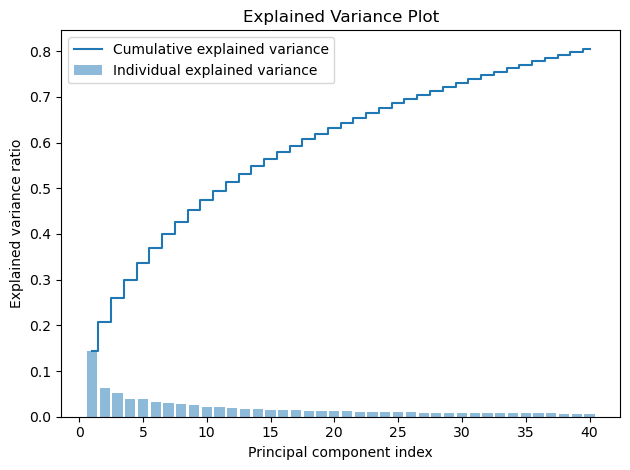

In [16]:
# Plot the explained variance.
plot_variance_explained(exp_var_pca_,cumsum_eigenvalue)

In [17]:
def loading_plot(loadings, feature_list, explained_variance): 
    """
    Create loading plot for given loadings (loadings), list with feature names (feature_list) 
    and array containing explained variance ratio for each principal component.
    
    Args:
        loadings (DataFrame): A DataFrame containing the loadings for each feature.
        feature_list (list): A list of feature names.
        explained_variance (list): A list of explained variance ratios for PC1 and PC2.

    Returns:
        The loading plot.
    """
    #Plot the coordinates with the name of the feature. 
    for i, txt in enumerate(feature_list):
        plt.annotate(txt, (loadings["PC1"][i], loadings["PC2"][i]))
    sns.scatterplot(data=loadings, x="PC1", y="PC2", hue=feature_list, legend=False)

    #Plot x- and y-axis. 
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    #Name x- and y-axis, explained ratio of PC1 and PC2 respectively. 
    plt.xlabel(f"PC1 ({explained_variance[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]*100:.2f}%)")
    plt.title('Loading Plot')
    
    return plt.show()

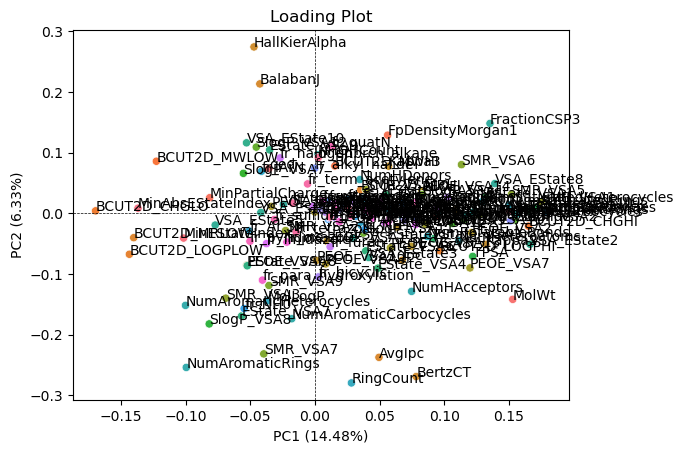

In [18]:
# Plot the loading plot.
loading_plot(loadings,names,exp_var_pca_)

In [19]:
def score_plot_activity(df, principal_components, explained_variance):
    """
    Create score plot with samples labeled by activity for given dataframe with data (df),
    dataframe containing principal components (principal_components)
    and array containing explained variance ratio for each principal component (explained_variance). 
    
    Args:
        df (DataFrame): Input DataFrame containing the data.
        principal_components (array-like): Principal components calculated from the input data.
        explained_variance (list or array-like): Explained variance ratios of PC1 and PC2.

    Returns:
        Score plot with samples labeled by activity. 
    """
    #Create dataframe with PC1 and PC2.
    pca_data = pd.DataFrame(principal_components[:, :2], columns=[0, 1])
    
    #Subtract activity ID data from the data. 
    activity_labels = data["ALDH1_inhibition"]
    
    #Add column with 'Activity' to the dataframe with PC1 and PC2. 
    pca_data["ALDH1_inhibition"] = activity_labels
    
    #Plot the samples of the created dataframe with for each activity a different colour. 
    activity_palette = sns.color_palette('hls', n_colors=len(pca_data["ALDH1_inhibition"].unique()))
    sns.scatterplot(data=pca_data, x=0, y=1,hue="ALDH1_inhibition", palette=activity_palette)
    
    #Plot x- and y-axis. 
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    #Name x- and y-axis, explained ratio of PC1 and PC2 respectively. 
    plt.xlabel(f"PC1 ({explained_variance[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]*100:.2f}%)")
    plt.title('PCA Score Plot; Activity')
    
    return plt.show()

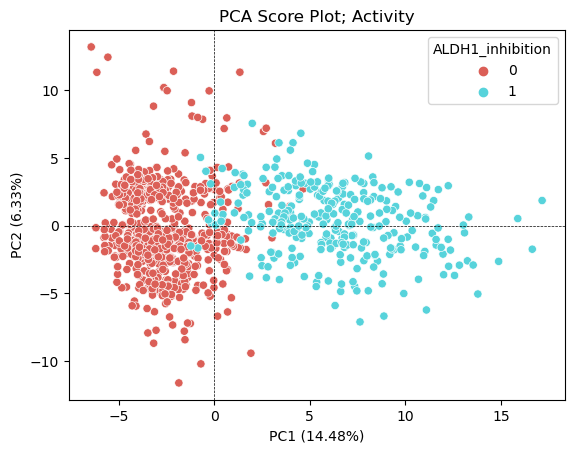

In [20]:
# Create a score plot grouped by inhibition yes or no.
score_plot_activity(df_scaled, principal_components, exp_var_pca_)

### Reduce descriptors using PCA

Using the loading and score plots side by side, we can determine a suitable number of descriptors for effectively describing the data. For now, we have chosen the top 10 descriptors from PC1 and the top 5 descriptors from PC2.

In [21]:
# Take the absolute value of all pca components (negative features are equivalently important as positive features)
# Select only the first two rows: only interested in PC1 and PC2
feature_contributions = abs(pca.components_[:2]) 

# Select the 10 best descriptors from PC1 and the 5 best descriptors from PC2
top_feature_pc1 = np.argsort(feature_contributions[0])[-10:]
top_feature_pc2 = np.argsort(feature_contributions[1])[-5:]

# Create a dataframe with only the selected descriptors (15 in total)
selected_features = np.unique(np.concatenate((top_feature_pc1, top_feature_pc2)))
selected_data = df_scaled.iloc[:, selected_features]

In [22]:
# Names of the 15 selected descriptors.
names_sel = selected_data.columns

Now perform PCA again to check if any valuable information has been lost in the process of selecting the features.

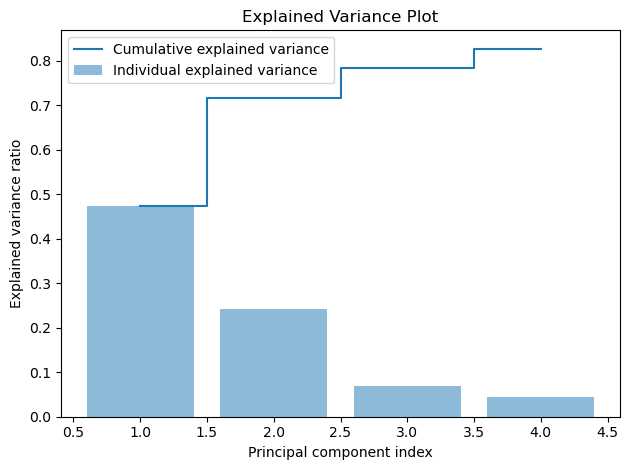

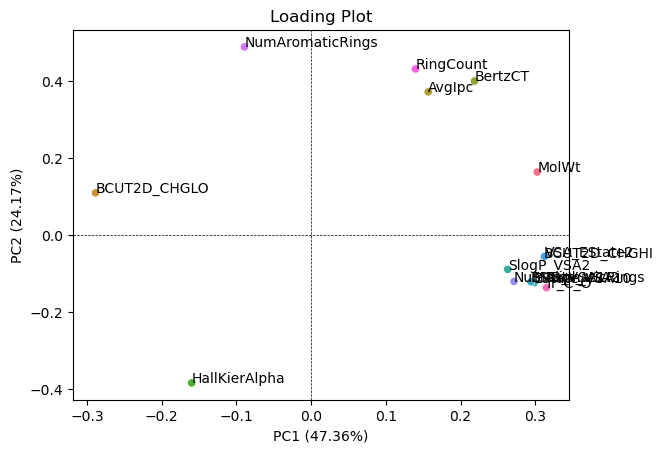

In [23]:
# Perform PCA again to check whether there is lost valuable information in selecting the descriptors
(pca_sel, 
 principal_components_sel, 
 exp_var_pca_sel, loadings_sel, 
 cumsum_eigenvalue_sel) = perform_pca(selected_data, 0.8, names_sel, ["PC1", "PC2", "PC3", "PC4"])

# Plot the explained variance of the selected data.
plot_variance_explained(exp_var_pca_sel,cumsum_eigenvalue_sel)

# Create loading plot of the selected data.
loading_plot(loadings_sel,names_sel,exp_var_pca_sel)

In [24]:
# Add ALDH1_inhibition column to df_selected_desc (necessary for adjusting the colors in the plot)
ALDH1_column = data["ALDH1_inhibition"]
selected_data["ALDH1_inhibition"] = ALDH1_column

C:\Users\20161641\AppData\Local\Temp\ipykernel_1692\808784633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data["ALDH1_inhibition"] = ALDH1_column


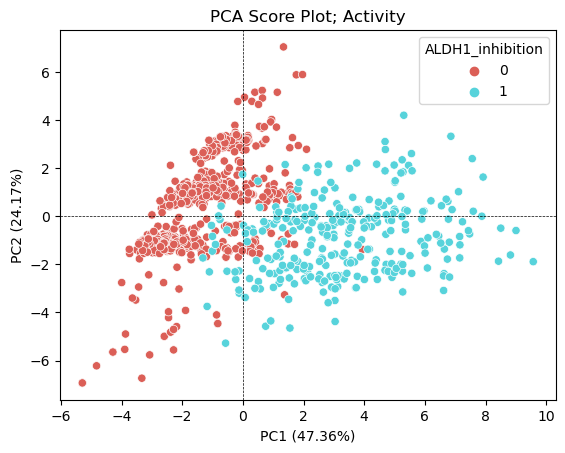

In [25]:
# Create score plot of the selected data.
score_plot_activity(selected_data, principal_components_sel, exp_var_pca_sel)


Further reduction of descriptors would result in a loss of information, so after experimenting, we have chosen this combination of descriptors.

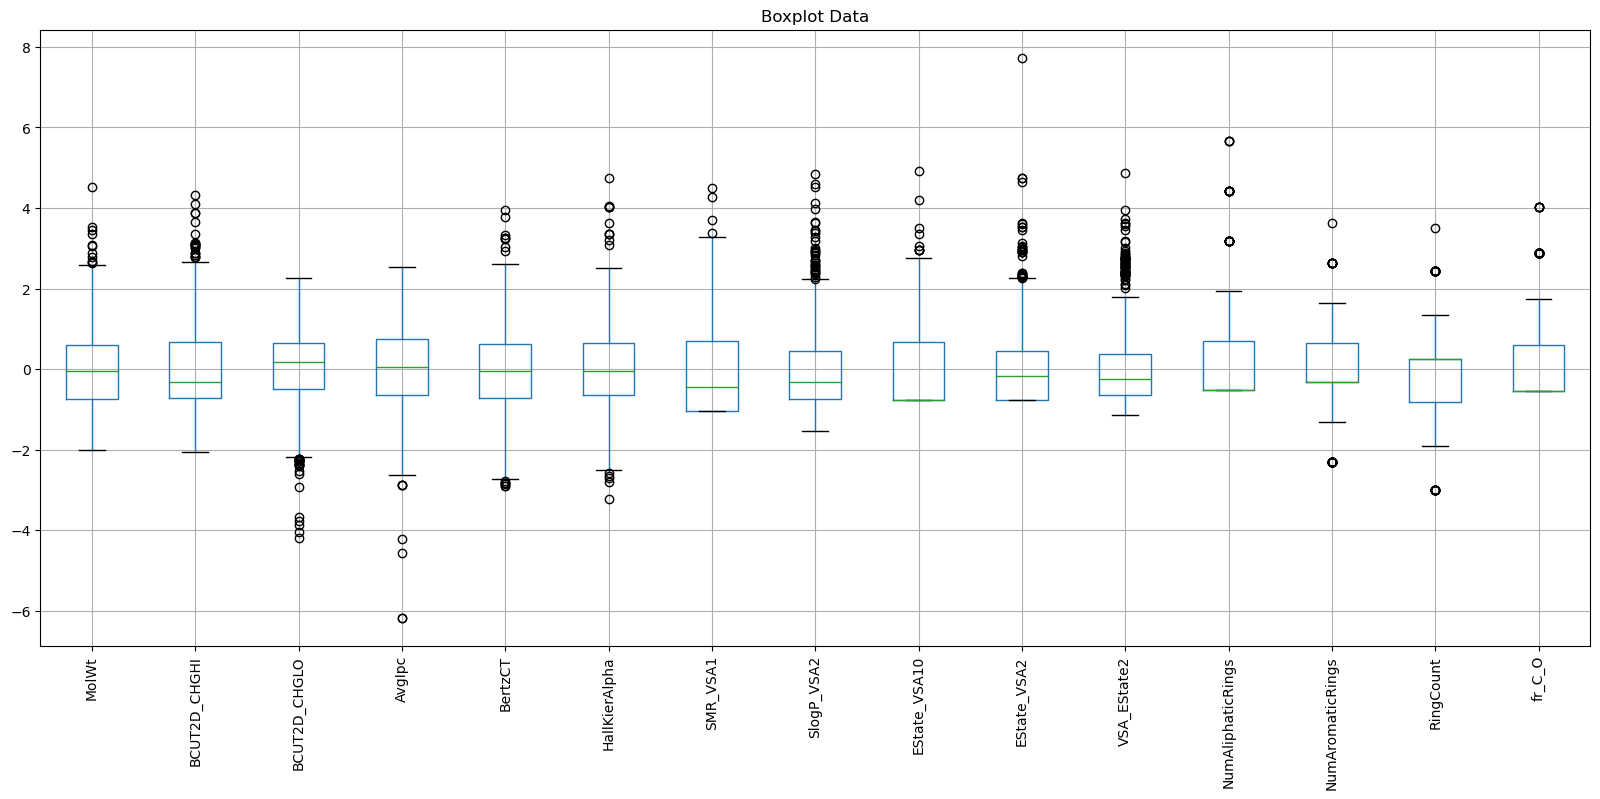

In [26]:
# create a boxplot of the 15 descriptors that are selected with the data after scaling
perform_boxplot(df_scaled[names_sel])

## Identification of structure-activity relationships

Using ML concepts or insights from EDA.

In [27]:
# Choose data to train the model with. 
Y = selected_data["ALDH1_inhibition"]

In [28]:
X = selected_data.drop('ALDH1_inhibition', axis=1)

In [29]:
# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [30]:
# Create a k-nearest neighbors classifier with a specified number of neighbors.
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
# Perform 10 fold cross validation with k=5 for knn.
neighbors = []
cv_scores = []

for k in range(1, 51, 2):
    neighbors.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(
                            knn, X_train, y_train, cv = 10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# Printing the accuracy scores of the 10 iterations X and Y
scores_balanced = cross_val_score(knn, X, Y, cv=10, scoring='balanced_accuracy')
print(scores_balanced)

[0.93333333 0.96666667 0.95952381 0.91666667 0.96904762 0.98333333
 0.96666667 0.95       0.98333333 0.92619048]


In [32]:
# Finding the optimal number of k neighbors.
MSE = [1-x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('The optimal number of K neighbors = %d' %optimal_k)

The optimal number of K neighbors = 1


In [33]:
# Get classification report.
model = KNeighborsClassifier(n_neighbors=optimal_k)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification report : \n\n")
print(classification_report(y_test, y_pred))

Classification report : 


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       143
           1       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



In [34]:
# Accuracy score of the prediction.
print('Accuracy of ALDH1_inhibitor prediction using knn =', balanced_accuracy_score(y_pred, y_test)*100)

Accuracy of ALDH1_inhibitor prediction using knn = 99.65277777777779


Text(113.9222222222222, 0.5, 'predicted class')

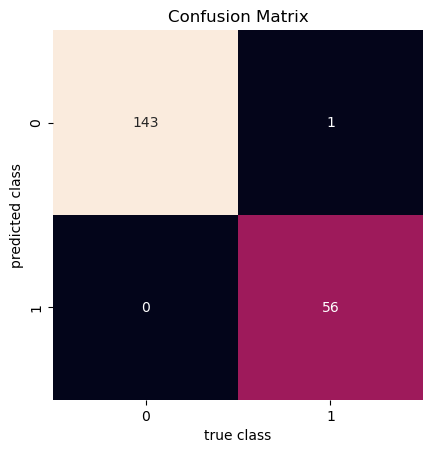

In [35]:
# Create confusion matrix.
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('true class')
plt.ylabel('predicted class')

## Selection of top 100 molecular candidates

In [36]:
# Load in the file from which we have to predict the inhibition score.
df_to_predict = load_data("untested_molecules.csv")

In [37]:
# Calculate descriptors for each SMILES string.
df_to_predict[desc_list] = df_to_predict['SMILES'].apply(calculate_descriptors)  

C:\Users\20161641\AppData\Local\Temp\ipykernel_1692\3300174469.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_to_predict[desc_list] = df_to_predict['SMILES'].apply(calculate_descriptors)
C:\Users\20161641\AppData\Local\Temp\ipykernel_1692\3300174469.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_to_predict[desc_list] = df_to_predict['SMILES'].apply(calculate_descriptors)
C:\Users\20161641\AppData\Local\Temp\ipykernel_1692\3300174469.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

In [38]:
# Removing SMILES to get a dataframe of only descriptor information.
predict_columns = data.columns[2:]
predict_descriptor = pd.DataFrame(df_to_predict[columns], columns=columns)

In [39]:
# Scale the dataframe with the descriptor information.
predict_scaled = perform_standard_scaling(predict_descriptor)

In [40]:
# Reduce the scaled dataframe by removing all descriptors not used for the prediction.
exclude_descriptors = names_sel.tolist()
reduced_predict = predict_scaled[exclude_descriptors]

In [41]:
# Predict the inhibition using the knn model.
predicted_labels = model.predict(reduced_predict)
predicted_probabilities = model.predict_proba(reduced_predict)[:, 1]

In [42]:
# Determine the distance from each prediction to the nearest neighbor.
distances, _ = model.kneighbors(reduced_predict, n_neighbors=1)

In [43]:
# Add two columns in the dataframe with SMILES and descriptor information 
# containing information about the prediction and the distance to the nearest neighbor.
df_to_predict['Predicted probability'] = predicted_probabilities
df_to_predict['Distance to neighbor'] = distances

In [44]:
# Sort the rows in the dataframe by the distance to the nearest neighbor.
# The largest distance corresponds to the best molecule to inhibit ALDH1.
df_sorted = df_to_predict.nlargest(10000, 'Distance to neighbor')

In [45]:
# Sort the rows in the sorted dataframe by predicted probability.
# The top 100 values now have both the largest distance and prediction of 1.
df_top_100 = df_sorted.nlargest(100, 'Predicted probability')

In [46]:
# Write the DataFrame to an Excel file
df_top_100.to_excel('top100_df.xlsx', index=False)

In [50]:
# Write only SMILES in the top 100 to an Excel file.
top_100_smiles = list(df_top_100['SMILES'])
df_top_100_smiles = pd.DataFrame(top_100_smiles)
df_top_100_smiles.to_csv('top100_CADD_technologies.csv', index=False)

When testing on the same data set, all molecules in the top 100 should have a score of one in the original file. To test this, test if the SMILES in the top 100 have a score of 1 in the original data set.

In [48]:
#count = 0

#for i, num in enumerate(df_to_predict["ALDH1_inhibition"]):
    #if num == 1:
        #if df_to_predict['SMILES'][i] in df_top_100.values:
            #count += 1
            
#print(count)